<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex05/Karen_Rosero/Aula_5_Exerc%C3%ADcio_Template_KarenRosero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
nome = 'Karen Rosero'
print(f'Meu nome é {nome}')

Meu nome é Karen Rosero


Este exercicío consiste em treinar no MNIST um modelo de umas camadas, sendo a primeira uma camada convolucional e a segunda uma camada linear de classificação.

Não podemos usar as funções torch.nn.Conv{1,2,3}d

## Importação das bibliotecas

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [3]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Define pesos iniciais

In [4]:
in_channels = 1
out_channels = 2
kernel_size = 5
stride = 3

# Input image size
height_in = 28  
width_in = 28

# Image size after the first convolutional layer.
height_out = (height_in - kernel_size) // stride + 1
width_out = (width_in - kernel_size) // stride + 1

initial_conv_weight = torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01)
initial_conv_bias = torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01)

initial_classification_weight = torch.FloatTensor(10, out_channels * height_out * width_out).uniform_(-0.01, 0.01)
initial_classification_bias = torch.FloatTensor(10,).uniform_(-0.01, 0.01)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [5]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [6]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [7]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

## Define os pesos iniciais

In [8]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [9]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Camada Convolucional

In [10]:
class MyConv2d(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size  # The same for height and width.
        self.stride = stride  # The same for height and width.
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01))
        self.bias = torch.nn.Parameter(torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01))

    def forward(self, x):
        assert x.dim() == 4, f'x must have 4 dimensions: {x.shape}'

        batch_size = x.shape[0]     
        h_in = x.shape[3] 
        w_in = x.shape[2] 
        p = 0 #padding, neste trabalho é zero

        # baseado na fórmula apresentada em https://cs231n.github.io/convolutional-networks/
        w_out = (h_in-self.kernel_size + p)//self.stride+1
        h_out = (w_in-self.kernel_size + p)//self.stride+1
        
        out = torch.zeros((batch_size, self.out_channels, h_out, w_out))
        
        for ch in range(self.out_channels):
            for w in range(self.kernel_size):
                for h in range(self.kernel_size):
                    lim_max_h = h_in-self.kernel_size+h
                    lim_max_w = w_in-self.kernel_size+w
                    conv = x[:, :, w:lim_max_w+1:self.stride, h:lim_max_h+1:self.stride]
                    # linha baseada no notebook de Larissa. Uso da função view
                    out[:,ch:ch+1,:,:] += (conv*self.weight[ch,0:self.in_channels,w,h].view(1,self.in_channels,1,1))
            out[:,ch:ch+1,:,:]+=self.bias[ch]

        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo simples

In [11]:
in_channels_dummy = 1
out_channels_dummy = 1
kernel_size_dummy = 2
stride_dummy = 1

conv_layer = MyConv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy)
pytorch_conv_layer = torch.nn.Conv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, padding=0)

# Usa os mesmos pesos para minha implementação e a do pytorch
initial_weights_dummy = torch.arange(in_channels_dummy * out_channels_dummy * kernel_size_dummy * kernel_size_dummy).float()
initial_weights_dummy = initial_weights_dummy.reshape(out_channels_dummy, in_channels_dummy, kernel_size_dummy, kernel_size_dummy)
initial_bias_dummy = torch.arange(out_channels_dummy,).float()

conv_layer.weight.data = initial_weights_dummy
conv_layer.bias.data = initial_bias_dummy
pytorch_conv_layer.load_state_dict(dict(weight=initial_weights_dummy, bias=initial_bias_dummy))

x = torch.arange(30).float().reshape(1, 1, 5, 6)

out = conv_layer(x)
target_out = pytorch_conv_layer(x)

assert torch.allclose(out, target_out, atol=1e-6)

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [12]:
x = torch.rand(2, in_channels, height_in, width_in)

conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
pytorch_conv_layer = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=0)

# Usa os mesmos pesos para minha implementação e a do pytorch
conv_layer.weight.data = initial_conv_weight
conv_layer.bias.data = initial_conv_bias
pytorch_conv_layer.load_state_dict(dict(weight=initial_conv_weight, bias=initial_conv_bias))

out = conv_layer(x)
target_out = pytorch_conv_layer(x)

assert torch.allclose(out, target_out, atol=1e-6)

## Modelo

In [13]:
class Net(torch.nn.Module):
    def __init__(self, height_in: int, width_in: int, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(Net, self).__init__()
        self.conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
   
        height_out = (height_in - kernel_size) // stride + 1
        width_out = (width_in - kernel_size) // stride + 1
        self.classification_layer = torch.nn.Linear(out_channels * height_out * width_out, 10)

    def forward(self, x):
        hidden = self.conv_layer(x)
        hidden = torch.nn.functional.relu(hidden)
        hidden = hidden.reshape(x.shape[0], -1)
        logits = self.classification_layer(hidden)
        return logits

## Treinamento

### Definição dos hiperparâmetros

In [14]:
n_epochs = 50
lr = 0.1

### Laço de treinamento

In [15]:
model = Net(height_in=height_in, width_in=width_in, in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)

# Usa pesos iniciais pré-difinidos
model.classification_layer.load_state_dict(dict(weight=initial_classification_weight, bias=initial_classification_bias))
model.conv_layer.weight.data = initial_conv_weight
model.conv_layer.bias.data = initial_conv_bias

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    for x_train, y_train in loader_train:
        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 2.303267478942871
Epoch: 1/49 Loss: 2.227701187133789
Epoch: 2/49 Loss: 1.0923893451690674
Epoch: 3/49 Loss: 0.5867354869842529
Epoch: 4/49 Loss: 0.5144088864326477
Epoch: 5/49 Loss: 0.4502663314342499
Epoch: 6/49 Loss: 0.4075140655040741
Epoch: 7/49 Loss: 0.37713873386383057
Epoch: 8/49 Loss: 0.3534485995769501
Epoch: 9/49 Loss: 0.3341451585292816
Epoch: 10/49 Loss: 0.3181140422821045
Epoch: 11/49 Loss: 0.30457887053489685
Epoch: 12/49 Loss: 0.2928348779678345
Epoch: 13/49 Loss: 0.2827608287334442
Epoch: 14/49 Loss: 0.2738332748413086
Epoch: 15/49 Loss: 0.26577427983283997
Epoch: 16/49 Loss: 0.2583288252353668
Epoch: 17/49 Loss: 0.25117501616477966
Epoch: 18/49 Loss: 0.24439716339111328
Epoch: 19/49 Loss: 0.2378995716571808
Epoch: 20/49 Loss: 0.23167717456817627
Epoch: 21/49 Loss: 0.22562651336193085
Epoch: 22/49 Loss: 0.21984528005123138
Epoch: 23/49 Loss: 0.21429124474525452
Epoch: 24/49 Loss: 0.20894214510917664
Epoch: 25/49 Loss: 0.2038729339838028
Epoch: 26/49 L

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

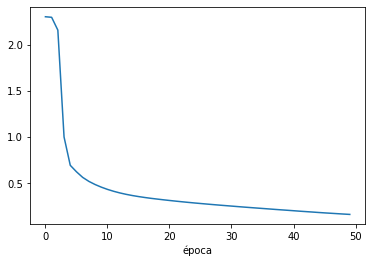

In [16]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [17]:
loss_epoch_end

[2.303267478942871,
 2.227701187133789,
 1.0923893451690674,
 0.5867354869842529,
 0.5144088864326477,
 0.4502663314342499,
 0.4075140655040741,
 0.37713873386383057,
 0.3534485995769501,
 0.3341451585292816,
 0.3181140422821045,
 0.30457887053489685,
 0.2928348779678345,
 0.2827608287334442,
 0.2738332748413086,
 0.26577427983283997,
 0.2583288252353668,
 0.25117501616477966,
 0.24439716339111328,
 0.2378995716571808,
 0.23167717456817627,
 0.22562651336193085,
 0.21984528005123138,
 0.21429124474525452,
 0.20894214510917664,
 0.2038729339838028,
 0.19903428852558136,
 0.19439975917339325,
 0.18994098901748657,
 0.18564006686210632,
 0.18147487938404083,
 0.1774490773677826,
 0.1734725534915924,
 0.1694747507572174,
 0.16547326743602753,
 0.1615050882101059,
 0.15746401250362396,
 0.15340447425842285,
 0.14926907420158386,
 0.14520640671253204,
 0.1412365883588791,
 0.13712678849697113,
 0.1331038475036621,
 0.12914668023586273,
 0.12515045702457428,
 0.1211676225066185,
 0.1173172593

In [18]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    2.303267478942871,
    2.227701187133789,
    1.0923893451690674,
    0.5867354869842529,
    0.5144089460372925,
    0.45026642084121704,
    0.4075140357017517,
    0.37713879346847534,
    0.3534485101699829,
    0.3341451585292816,
    0.3181140422821045,
    0.30457887053489685,
    0.29283496737480164,
    0.2827608287334442,
    0.2738332152366638,
    0.2657742500305176,
    0.2583288848400116,
    0.25117507576942444,
    0.24439716339111328,
    0.23789969086647034,
    0.23167723417282104,
    0.22562651336193085,
    0.21984536945819855,
    0.2142913043498993,
    0.20894232392311096,
    0.203872948884964,
    0.19903430342674255,
    0.19439971446990967,
    0.18994088470935822,
    0.18563991785049438,
    0.18147490918636322,
    0.17744913697242737,
    0.17347246408462524,
    0.16947467625141144,
    0.16547319293022156,
    0.16150487959384918,
    0.1574639081954956,
    0.1534043848514557,
    0.14926929771900177,
    0.1452063024044037,
    0.1412365883588791,
    0.13712672889232635,
    0.1331038922071457,
    0.1291467249393463,
    0.1251506358385086,
    0.12116757035255432,
    0.11731722950935364,
    0.11364627629518509,
    0.11001908034086227,
    0.10655981302261353])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)